In [ ]:
import numpy as np
import scipy.linalg
import scipy.integrate
import matplotlib.pyplot as plt

# Week 9 Lecture 3: Boundary Value Problems
## Rahman notes:
### Shooting method

First let's use the "shooting method".  With this method we solve the problem as an initial value problem, and use root finding to match the value on the other side.  For example, with
$ \ddot{x} = 0$, with $x(0) = x_0$ and $x(T) = x_T$.

We start by solving $ \ddot{x} = 0$, with $x(0) = x_0$, $x'(0) = v_1$ and $ \ddot{x} = 0$, with $x(0) = x_0$, $x'(0) = v_2$ such that the first IVP produces $x(T) = x_a > x_T$ and the second IVP produces $x(T) = x_b < x_T$.  Now, using bisection we can adjust until we match $x(T) \approx x_T$.

Let's try this with

$ \ddot{x} = 0$, with $x(0) = 1$ and $x(3) = 5$.

In [ ]:
x0 = 1
v1 = 0
v2 = 1
T = 3
dt = 0.01
t = np.arange(0, T + dt, dt)

def myODE(t, x):
    dx1 = x[1]
    dx2 = 0
    dx = np.array([dx1, dx2])
    return dx

### Test for v1 and v2
sol = scipy.integrate.solve_ivp(myODE, (0, T), np.array([x0, v1]), t_eval=t)
print(sol.y[0,-1])
sol = scipy.integrate.solve_ivp(myODE, (0, T), np.array([x0, v2]), t_eval=t)
print(sol.y[0,-1])

1.0
4.0


That's no good because they are both less than 5.  Lets not change v2, but lets try to find v1 that will give us a value greater than 5.

In [ ]:
v1 = 2
sol = scipy.integrate.solve_ivp(myODE, (0, T), np.array([x0, v1]), t_eval=t)
print(sol.y[0,-1])

7.0


This works because one is bigger than 5 and the other is less than 5.  Now let's write our bisection scheme.

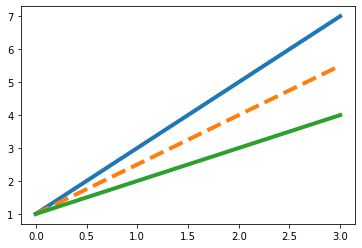

In [ ]:
x0 = 1
xT = 5
T = 3
dt = 0.01
t = np.arange(0, T + dt, dt)

def myODE(t, x):
    dx1 = x[1]
    dx2 = 0
    dx = np.array([dx1, dx2])
    return dx

v1 = 2
v2 = 1
v_mid = (v1+v2)/2

sol = scipy.integrate.solve_ivp(myODE, (0, T), np.array([x0, v1]), t_eval=t)
x_a = sol.y[0,:]
sol = scipy.integrate.solve_ivp(myODE, (0, T), np.array([x0, v2]), t_eval=t)
x_b = sol.y[0,:]
sol = scipy.integrate.solve_ivp(myODE, (0, T), np.array([x0, v_mid]), t_eval=t)
x_mid = sol.y[0,:]

plt.plot(t, x_a, t, x_mid, '--', t, x_b, linewidth = 4)

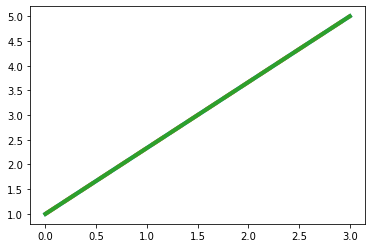

In [ ]:
for i in range(100):
  if x_mid[-1] == xT:
    break
  elif np.sign(x_mid[-1]-xT) == np.sign(x_a[-1]-xT):
    v1 = v_mid
    sol = scipy.integrate.solve_ivp(myODE, (0, T), np.array([x0, v1]), t_eval=t)
    x_a = sol.y[0,:]
  else:
      v2 = v_mid
      sol = scipy.integrate.solve_ivp(myODE, (0, T), np.array([x0, v2]), t_eval=t)
      x_b = sol.y[0,:]

  v_mid = (v1+v2)/2
  sol = scipy.integrate.solve_ivp(myODE, (0, T), np.array([x0, v_mid]), t_eval=t)
  x_mid = sol.y[0,:]

plt.plot(t, x_a, t, x_mid, '--', t, x_b, linewidth = 4)

This very quickly converges to the true solution.  To see how the algorithm is working it may be useful to test it out with v1 and v2 that gives us a much larger gap.

## Finite Differences
### I borrowed the old notes for this, but changed a few things up in the video.
We will now start to develop a method for solving boundary value problems numerically.  In particular, we will start by solving the problem 

$\ddot{x} = 0$ with $x(0) = x_0$ and $x(T) = x_T$.  

We already know that the solution is 

$x(t) = \frac{x_T - x_0}{T}t + x_0$, 

and we would love to find a numerical method that would give us this formula for $x(t)$.  Unfortunately, this is generally a hopeless task.  (For more complicated equations, it is usually not even possible on paper, and it is certainly not something we can expect python to do.)  Instead, we will try to approximate $x(t)$ at many different times.  In particular, we will use the same setup that we had for initial value problems and choose a set of evenly spaced $t$ values: $t_0$, $t_1$, $t_2$, $\dotsc$, $t_{N-1}$, $t_N$.  In general, it only really makes sense to solve a boundary value problem between the two times used for boundary conditions, so we will choose $t_0 = 0$ and $t_N = T$.  Since these times are evenly spaced, we can write each time as $t_k = k\Delta t$, where $\Delta t = T/N$.  

Our goal is to find the values of $x$ at each of these $t$ values.  That is, we would like to find $x(t_0)$, $x(t_1)$, $x(t_2)$, $\dotsc$, $x(t_{N-1})$, $x(t_N)$.  Of course, we can't hope to find those values exactly with a numerical method, so we will only obtain approximations $x_0$, $x_1$, $x_2$, $\dotsc$, $x_{N-1}$, $x_N$.  We therefore need to find an equation (or several equations) for these $x_k$'s.  Actually, we already know two of these points.  $x_0$ is just our first boundary condition and $x_N = x_T$ is just our second boundary condition.  We therefore only have to solve for $x_1$ through $x_{N-1}$.  We call these $x$ values the *interior values* (as opposed to the boundary values) and the corresponding times $t_1$ through $t_{N-1}$ are called the *interior points* (or interior times).  Notice that there are $N + 1$ total points, but only $N - 1$ interior points.  

The key to our approach is to approximate the second derivative $\ddot{x}$ in our differential equation with a finite difference scheme.  In particular, we already saw in last week's activity that we could approximate the second derivative of a function $f(t)$ with the second order central difference scheme 

$f''(t) \approx \frac{f(t - \Delta t) - 2f(t) + f(t + \Delta t)}{\Delta t^2}$.  

Translating this into our new notation, we have 

$\ddot{x}(t) \approx \frac{x(t - \Delta t) - 2x(t) + x(t + \Delta t)}{\Delta t^2}$.  

This is true for any time $t$.  In particular, we could use the first interior time $t_1$, which gives us the equation 

$\ddot{x}(t_1) \approx \frac{x(t_1 - \Delta t) - 2x(t_1) + x(t_1 + \Delta t)}{\Delta t^2} = \frac{x(t_0) - 2x(t_1) + x(t_2)}{\Delta t^2}$.  

We don't know what $x(t_1)$ or $x(t_2)$ are, but we do know that this expression is supposed to be approximately equal to zero (because $\ddot{x}(t) = 0$ for any time).  We can just use this as the definition of our approximations: 

$\frac{x_0 - 2x_1 + x_2}{\Delta t^2} = 0$.  

Similarly, if we plug in $t = t_2$, we get the equation

$\ddot{x}(t_2) \approx \frac{x(t_2 - \Delta t) - 2x(t_2) + x(t_2 + \Delta t)}{\Delta t^2} = \frac{x(t_1) - 2x(t_2) + x(t_3)}{\Delta t^2}$.  

Again, we know that this is supposed to be approximately equal to zero, so we can take this as a definition for our approximations: 

$\frac{x_1 - 2x_2 + x_3}{\Delta t^2} = 0$.  

We can repeat this process for any interior time $t_k$ and we get the formula 

$\frac{x_{k-1} - 2x_k + x_{k+1}}{\Delta t^2} = 0$.  

We therefore have the following system of equations: 

$(1 / \Delta t^2)(x_0 - 2x_1 + x_2) = 0$, 

$(1 / \Delta t^2)(x_1 - 2x_2 + x_3) = 0$, 

$\cdots$

$(1 / \Delta t^2)(x_{N-3} - 2x_{N-2} + x_{N-1}) = 0$, 

$(1 / \Delta t^2)(x_{N-2} - 2x_{N-1} + x_N) = 0$.  

Notice that there are only $N - 1$ equations here, because we only plugged in interior times, not the boundary times.  (If we used boundary times $t_0$ or $t_N$ in these equations, then we would need $t$ and $x$ values from outside of our interval $[0, T]$.)

Also note that $x_0$ and $x_N$ are actually already known - they are our boundary values - and so we should really move them over to the right side of our equations.  We are then left with 

$(1 / \Delta t^2)(-2x_1 + x_2) = -x_0/\Delta t^2$, 

$(1 / \Delta t^2)(x_1 - 2x_2 + x_3) = 0$, 

$\cdots$

$(1 / \Delta t^2)(x_{N-3} - 2x_{N-2} + x_{N-1}) = 0$, 

$(1 / \Delta t^2)(x_{N-2} - 2x_{N-1}) = -x_T/\Delta t^2$.  

This is a linear system of equations for the interior values $x_1$, $\dotsc$, $x_{N-1}$, and so we can rewrite it as a matrix equation $A\mathbf{x} = \mathbf{b}$.  We get 

$\frac{1}{\Delta t^2}\begin{pmatrix} -2 & 1 & 0 & \cdots & 0 \\ 1 & -2 & 1 & \cdots & 0 \\ \vdots & \ddots & \ddots & \ddots & \vdots \\ 0 & \cdots & 1 & -2 & 1 \\ 0 & \cdots & 0 & 1 & -2 \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_{N-2} \\ x_{N-1} \end{pmatrix} = \begin{pmatrix} -x_0/\Delta t^2 \\ 0 \\ \vdots \\ 0 \\ -x_T/\Delta t^2 \end{pmatrix}$.

We know several methods to solve a system like this.  We could use Gaussian elimination, $LU$ decomposition, or even an iterative method like Jacobi or Gauss-Seidel.  We will just use the `solve` function, but this is another example of why linear systems are so important in numerics.  

Notice that this is not a time stepping method, unlike the methods we developed for initial value problems.  That is, we can't solve for $x_1$ and then $x_2$ and then $x_3$, etc.  Instead, we have to solve the whole system at once.  

As an example, let's implement this in python to solve 

$\ddot{x} = 0$ with $x(0) = 1$ and $x(3) = 5$.  

We will choose $\Delta t = 0.1$.  

In [ ]:
x0 = 1
xT = 5
T = 3
dt = 0.1

t = np.arange(0, T + dt, dt)
n = t.size

Notice that $n$ is the total number of points, including the boundary points.  There are only $n - 2$ interior points, so we need to make an $(n - 2)\times (n - 2)$ system of equations.  We can make a matrix of the right form with the code 

In [ ]:
v = -2 * np.ones(n - 2)
u = np.ones(n - 3)
A = (1 / dt ** 2) * (np.diag(v) + np.diag(u, 1) + np.diag(u, -1))

You already constructed this matrix in a homework problem, so I won't spend any extra time explaining the code above.  

We also have to make the vector $\mathbf{b}$ for the right hand side.  This vector is mostly zeros, but the first and last entry depend on the boundary conditions.  We can implement this in python with 

In [ ]:
b = np.zeros((n - 2, 1))
b[0] = -x0 / dt ** 2
b[-1] = -xT / dt ** 2

Finally, we can solve for all of the interior $x$ values with the command 

In [ ]:
x_int = scipy.linalg.solve(A, b)

Keep in mind that this vector does not include the boundary values.  Usually we want to know all of the $x$ values, not just the interior values, but this is easy to fix.  The first and last $x$ values are just the two boundary conditions, so we can write 

In [ ]:
x = np.zeros(n)
x[0] = x0
x[1:-1] = x_int.reshape(-1)
x[-1] = xT

Note that we made `x` a 1D array instead of a column vector.  Since we are done with linear algebra for this problem, it is easier to work with 1D arrays.  (For instance, the plot function does not work well with column vectors.)

We can now plot our approximation alongside the true solution.  

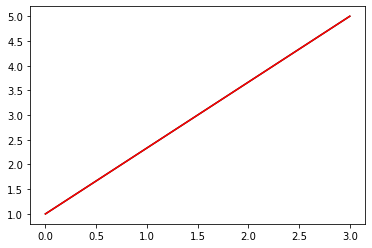

In [ ]:
x_true = lambda t: (xT - x0) / T * t + x0
plt.plot(t, x_true(t), 'k', t, x, 'r')

We can't even see both curves, which is a good sign that we found a good approximation.  To confirm, we could check the maximum error.  

In [ ]:
print(np.max(np.abs(x - x_true(t))))

2.6645352591003757e-15


This error is quite small, so we did indeed find a good approximation.  In general, we can't expect the error to be quite this small, but it turns out that this differential equation was so simple that our difference scheme was actually exact.  Because of that, the only error actually arose from the `solve` function and not our BVP solver.  

## Numerical Solutions - Variations
There are a few common variations of this problem that are worth looking at.  First, consider the problem 

$\ddot{x} = f(t)$ with $x(0) = x_0$ and $x(T) = x_T$.  

Here, $f$ is some function of time (and not of $x$).  We can follow the same approach as before.  We approximate our equation using a difference scheme and get 

$\ddot{x}(t) \approx \frac{x(t - \Delta t) - 2x(t) + x(t + \Delta t)}{\Delta t^2} \approx f(t)$.  

This is valid for any time $t$, so we can plug in any of our interior times $t_k$.  In general, we get the formula

$\ddot{x}(t_k) \approx \frac{x(t_{k-1}) - 2x(t_k) + x(t_{k+1})}{\Delta t^2} \approx f(t_k)$, 

and so we can define our approximations by 

$\frac{x_{k-1} - 2x_k + x_{k+1}}{\Delta t^2} = f(t_k)$.  

Following the same approach as before, we get the system of equations 

$(1 / \Delta t^2)(x_0 - 2x_1 + x_2) = f(t_1)$, 

$(1 / \Delta t^2)(x_1 - 2x_2 + x_3) = f(t_2)$, 

$\cdots$

$(1 / \Delta t^2)(x_{N-3} - 2x_{N-2} + x_{N-1}) = f(t_{N-2})$, 

$(1 / \Delta t^2)(x_{N-2} - 2x_{N-1} + x_N) = f(t_{N-1})$, 

and so 

$(1 / \Delta t^2)(-2x_1 + x_2) = f(t_1) - x_0/\Delta t^2$, 

$(1 / \Delta t^2)(x_1 - 2x_2 + x_3) = f(t_2)$, 

$\cdots$

$(1/\Delta t^2)(x_{N-3} - 2x_{N-2} + x_{N-1})$, 

$(1/\Delta t^2)(-2x_{N-1} + x_N) = f(t_{N-1}) - x_T/\Delta t^2$.

This is a linear system of equations, and so we can write it as the matrix equation 

$\frac{1}{\Delta t^2}\begin{pmatrix} -2 & 1 & 0 & \cdots & 0 \\ 1 & -2 & 1 & \cdots & 0 \\ \vdots & \ddots & \ddots & \ddots & \vdots \\ 0 & \cdots & 1 & -2 & 1 \\ 0 & \cdots & 0 & 1 & -2 \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_{N-2} \\ x_{N-1} \end{pmatrix} = \begin{pmatrix} f(t_1) - x_0/\Delta t^2 \\ f(t_2) \\ \vdots \\ f(t_{N-2}) \\ f(t_{N-1}) - x_T/\Delta t^2 \end{pmatrix}$.  

As an example, let's solve the boundary value problem 

$\ddot{x} = e^{-2t}$ with $x(0) = 2$ and $x(3) = 10$.  

It is easy to check that the exact solution to this boundary value problem is 

$x(t) = \frac{1}{4}e^{-2t} + \left(\frac{33}{12} - \frac{1}{12}e^{-6}\right)t + \frac{7}{4}$.  

We can approximate this solution numerically with the following code (using $\Delta t = 0.1$): 

In [ ]:
x0 = 2
xT = 10
T = 3
dt = 0.1
t = np.arange(0, T + dt, dt)
n = t.size

v = -2 * np.ones(n - 2)
u = np.ones(n - 3)
A = (1 / dt ** 2) * (np.diag(v) + np.diag(u, 1) + np.diag(u, -1))
b = np.exp(-2 * t[1:-1])
b[0] = b[0] - x0 / dt ** 2
b[-1] = b[-1] - xT / dt ** 2
b = b.reshape((-1, 1))

x_int = scipy.linalg.solve(A, b)

x = np.zeros(n)
x[0] = x0
x[1:-1] = x_int.reshape(-1)
x[-1] = xT

This code is nearly identical to our last version, except for the construction of `b`.  We can compare this approximation to the true solution to see how we did: 

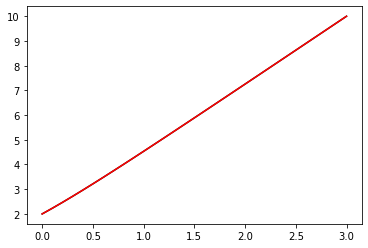

In [ ]:
x_true = lambda t: (1 / 4) * np.exp(-2 * t) + ((33 / 12) - (1 / 12) * np.exp(-6)) * t + (7 / 4)
plt.plot(t, x_true(t), 'k', t, x, 'r')

In [ ]:
print(np.max(np.abs(x - x_true(t))))

0.0004453129545041179


The error is still quite small, which suggests that our method is working.  If we shrink $\Delta t$ by a factor of 10 and then repeat this process, we get 

In [ ]:
x0 = 2
xT = 10
T = 3
dt = 0.01
t = np.arange(0, T + dt, dt)
n = t.size

v = -2 * np.ones(n - 2)
u = np.ones(n - 3)
A = (1 / dt ** 2) * (np.diag(v) + np.diag(u, 1) + np.diag(u, -1))
b = np.exp(-2 * t[1:-1])
b[0] = b[0] - x0 / dt ** 2
b[-1] = b[-1] - xT / dt ** 2
b = b.reshape((-1, 1))

x_int = scipy.linalg.solve(A, b)

x = np.zeros(n)
x[0] = x0
x[1:-1] = x_int.reshape(-1)
x[-1] = xT

print(np.max(np.abs(x - x_true(t))))

4.461950123157976e-06


Notice that shrinking $\Delta t$ by a factor of 10 decreased the error by a factor of $10^2$.  This suggests that the method is second order accurate, which makes sense since we used a second order difference scheme to approximate $\ddot{x}$.  

Now consider the problem 

$\ddot{x} + x = 0$ with $x(0) = x_0$ and $x(T) = x_T$.  

In particular, if we choose $x_0 = 0$ then we know that (as long as $\sin(T) \neq 0$) the solution is 

$x(t) = \frac{x_T}{\sin(T)}\sin(t)$.  

We can follow the same approach as before.  If we approximate our differential equation with a difference scheme then we find that 

$\ddot{x}(t) + x(t) \approx \frac{x(t - \Delta t) - 2x(t) + x(t + \Delta t)}{\Delta t^2} + x(t) \approx 0$.  

This is valid for any time $t$, so we can plug in any of our interior times $t_k$.  In general, we get the formula 

$\frac{x(t_{k-1}) - 2x(t_k) + x(t_{k+1})}{\Delta t^2} + x(t_k) \approx 0$, 

and so we can define our approximations by 

$\frac{x_{k-1} - 2x_k + x_{k+1}}{\Delta t^2} + x_k = 0$.  

Following the same approach as before, we get the system of equations 

$(1 / \Delta t^2)(x_0 - 2x_1 + x_2) + x_1 = 0$, 

$(1 / \Delta t^2)(x_1 - 2x_2 + x_3) + x_2 = 0$, 

$\cdots$

$(1 / \Delta t^2)(x_{N-3} - 2x_{N-2} + x_{N-1}) + x_{N-2} = 0$, 

$(1 / \Delta t^2)(x_{N-2} - 2x_{N-1} + x_N) + x_{N-1} = 0$, 

and so

$(1 / \Delta t^2)(-2x_1 + x_2) + x_1 = -x_0 / \Delta t^2$,

$(1 / \Delta t^2)(x_1 - 2x_2 + x_3) + x_2 = 0$, 

$\cdots$

$(1 / \Delta t^2)(x_{N-3} - 2x_{N-2} + x_{N-1}) + x_{N-2} = 0$, 

$(1 / \Delta t^2)(x_{N-2} - 2x_{N-1}) + x_{N-1} = -x_T/\Delta t^2$.  

This is a linear system of equations, and so we can write it as the matrix equation

$\frac{1}{\Delta t^2}\begin{pmatrix} -2 & 1 & 0 & \cdots & 0 \\ 1 & -2 & 1 & \cdots & 0 \\ \vdots & \ddots & \ddots & \ddots & \vdots \\ 0 & \cdots & 1 & -2 & 1 \\ 0 & \cdots & 0 & 1 & -2 \end{pmatrix}\begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_{N-2} \\ x_{N-1} \end{pmatrix} + \begin{pmatrix} 1 & 0 & 0 & \cdots & 0 \\ 0 & 1 & 0 & \cdots & 0 \\ \vdots & \ddots & \ddots & \ddots & \vdots \\ 0 & 0 & \cdots & 1 & 0 \\ 0 & 0 & \cdots & 0 & 1 \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \\ \vdots \\ x_{N-2} \\ x_{N-1} \end{pmatrix} = \begin{pmatrix} -x0 / \Delta t^2 \\ 0 \\ \vdots \\ 0 \\ -x_T/\Delta t^2 \end{pmatrix}$.  

Let's name the first matrix (including the $1/\Delta t^2$ factor) $A$.  The second matrix is the $(N - 1)\times (N - 1)$ identity matrix.  (That is, it has 1's down the main diagonal and zeros everywhere else.)  The identity matrix is usually denoted by an $I$, so we have the equation 

$A\mathbf{x} + I\mathbf{x} = \mathbf{b}$, 

which we can simplify to 

$(A + I)\mathbf{x} = \mathbf{b}$.  

As an example, let's implement this method in python with $x_0 = 0$, $x_T = 5$ and $T = 3$, using $\Delta t = 0.1$).  We get 

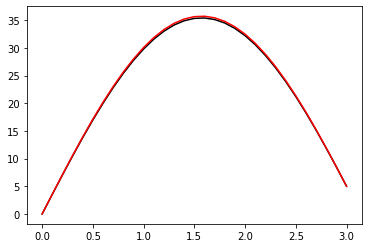

In [ ]:
x0 = 0
xT = 5
T = 3
dt = 0.1
t = np.arange(0, T + dt, dt)
n = t.size

v = -2 * np.ones(n - 2)
u = np.ones(n - 3)
A = (1 / dt ** 2) * (np.diag(v) + np.diag(u, 1) + np.diag(u, -1))
I = np.eye(n - 2)
b = np.zeros(n - 2)
b[0] = -x0 / dt ** 2
b[-1] = -xT / dt ** 2
b = b.reshape((-1, 1))

x_int = scipy.linalg.solve(A + I, b)

x = np.zeros(n)
x[0] = x0
x[1:-1] = x_int.reshape(-1)
x[-1] = xT

x_true = lambda t: (xT / np.sin(T)) * np.sin(t)
plt.plot(t, x_true(t), 'k', t, x, 'r')

In [ ]:
print(np.max(np.abs(x - x_true(t))))

0.3146173340071101


This is a larger error than before, but we can still improve it by reducing $\Delta t$.  In particular, if we reduce $\Delta t$ by a factor of ten then we have 

In [ ]:
x0 = 0
xT = 5
T = 3
dt = 0.01
t = np.arange(0, T + dt, dt)
n = t.size

v = -2 * np.ones(n - 2)
u = np.ones(n - 3)
A = (1 / dt ** 2) * (np.diag(v) + np.diag(u, 1) + np.diag(u, -1))
I = np.eye(n - 2)
b = np.zeros(n - 2)
b[0] = -x0 / dt ** 2
b[-1] = -xT / dt ** 2
b = b.reshape((-1, 1))

x_int = scipy.linalg.solve(A + I, b)

x = np.zeros(n)
x[0] = x0
x[1:-1] = x_int.reshape(-1)
x[-1] = xT

print(np.max(np.abs(x - x_true(t))))

0.003115144797007474


The error went down by a factor of $10^2$, which confirms that this is a second order accurate method.  

## Problems With No Solution
Remember that not all boundary value problems have a solution.  In particular, we saw that the problem 

$\ddot{x} + x = 0$ with $x(0) = x_0$ and $x(\pi) = 5$

does not have a solution.  What happens when we try to solve this problem using our numerical method?  

In [ ]:
x0 = 0
xT = 5
T = np.pi
dt = 0.1
t = np.arange(0, T + dt, dt)
n = t.size

v = -2 * np.ones(n - 2)
u = np.ones(n - 3)
A = (1 / dt ** 2) * (np.diag(v) + np.diag(u, 1) + np.diag(u, -1))
I = np.eye(n - 2)
b = np.zeros(n - 2)
b[0] = -x0 / dt ** 2
b[-1] = -xT / dt ** 2
b = b.reshape((-1, 1))

x_int = scipy.linalg.solve(A + I, b)

x = np.zeros(n)
x[0] = x0
x[1:-1] = x_int.reshape(-1)
x[-1] = xT

It no longer makes sense to calculate the error, but we can still plot our approximate solution.  

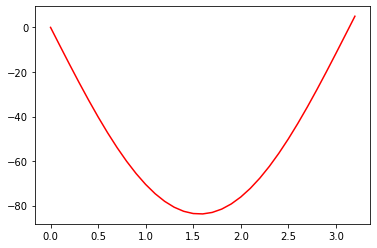

In [ ]:
plt.plot(t, x, 'r')

We got an answer, and it even looks like a sin curve of some variety, but remember that there isn't supposed to be a solution.  What is going on here?  To see the problem, let's try using a smaller $\Delta t$.  If there was a unique solution, we would expect to get closer to it as we made $\Delta t$ smaller.  

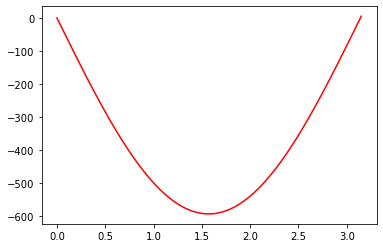

In [ ]:
x0 = 0
xT = 5
T = np.pi
dt = 0.01
t = np.arange(0, T + dt, dt)
n = t.size

v = -2 * np.ones(n - 2)
u = np.ones(n - 3)
A = (1 / dt ** 2) * (np.diag(v) + np.diag(u, 1) + np.diag(u, -1))
I = np.eye(n - 2)
b = np.zeros(n - 2)
b[0] = -x0 / dt ** 2
b[-1] = -xT / dt ** 2
b = b.reshape((-1, 1))

x_int = scipy.linalg.solve(A + I, b)

x = np.zeros(n)
x[0] = x0
x[1:-1] = x_int.reshape(-1)
x[-1] = xT

plt.plot(t, x, 'r')

Notice the scale on the $y$ axis.  Our approximations are not getting closer to anything.  Instead, they are growing infinitely large as we shrink $\Delta t$.  This is typical behavior when the BVP doesn't have a solution.  The numerical method will always give you an answer, but those answers won't converge as you shrink $\Delta t$.  

## Problems With Many Solutions
Similarly, we know that the BVP 

$\ddot{x} + x = 0$ with $x(0) = 0$ and $x(\pi) = 0$ 

has infinitely many solutions.  If we try to solve this with our numerical method, we get 

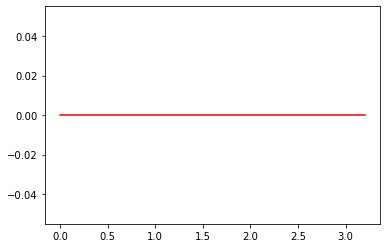

In [ ]:
x0 = 0
xT = 0
T = np.pi
dt = 0.1
t = np.arange(0, T + dt, dt)
n = t.size

v = -2 * np.ones(n - 2)
u = np.ones(n - 3)
A = (1 / dt ** 2) * (np.diag(v) + np.diag(u, 1) + np.diag(u, -1))
I = np.eye(n - 2)
b = np.zeros(n - 2)
b[0] = -x0 / dt ** 2
b[-1] = -xT / dt ** 2
b = b.reshape((-1, 1))

x_int = scipy.linalg.solve(A + I, b)

x = np.zeros(n)
x[0] = x0
x[1:-1] = x_int.reshape(-1)
x[-1] = xT

plt.plot(t, x, 'r')

In this case, we get $x(t) = 0$, which really is a solution to our differential equation.  It turns out that we will still get the same answer no matter how we change $\Delta t$.  This behavior is a little less common.  In general, if your BVP has many solutions, then the numerical solutions might converge to one of those solutions or they might not converge at all.  